# Проект для «Викишоп» c BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Цель: научить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

Необходимо построить модель со значением метрики качества *F1* не меньше 0.75. 

**План выполнения проекта**

1. Загрузить и подготовить данные.
2. Обучить разные модели. 
3. Сделать выводы.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

Прект был выполнен в Google Colab. Данный сервис предлагает бесплатные графические процессоры. Поскольку мы будем обучать большую нейронную сеть, лучше всего воспользоваться этим преимуществом, иначе обучение занимает очень много времени.

Выполним код из ячейки ниже, чтобы проверить подключение к GPU

## Подготовка

In [ ]:
!pip install pytorch-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 176 kB 8.5 MB/s 
     |████████████████████████████████| 1.3 MB 66.3 MB/s 
     |████████████████████████████████| 880 kB 60.9 MB/s 
     |████████████████████████████████| 132 kB 67.3 MB/s 
     |████████████████████████████████| 79 kB 9.4 MB/s 
     |████████████████████████████████| 9.2 MB 49.5 MB/s 
     |████████████████████████████████| 140 kB 56.9 MB/s 
     |████████████████████████████████| 127 kB 52.7 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=13b11a0b23054d7ee90933cef4dbe3600082909358f5012e390a3d3135f41949
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import time
import re
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score,make_scorer,accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
from sklearn.pipeline import Pipeline

from pytorch_transformers import BertTokenizer, BertConfig,AdamW, BertForSequenceClassification

from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
import io

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
print(torch.cuda.is_available(), # Проверка наличия GPU
torch.cuda.device_count(), # Сколько GPU доступно
torch.cuda.current_device(), # Какое подключено
torch.cuda.get_device_name(0)) # Имя GPU

True 1 0 Tesla T4


In [ ]:
#размер графиков
sns.set(rc={"figure.figsize":(12, 6)})
#темная тема для графиков
plt.style.use('dark_background')

In [ ]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv', index_col='Unnamed: 0')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [ ]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0



Данные загружены корректно, первичный осмотр проведен. Пропусков нет, в нашем распоряжении почти 160000 коментариев

Отношение токсичные / нетокичные комментарии целевого признака

In [ ]:
df['toxic'].value_counts()/len(df['toxic'])

0    0.898388
1    0.101612
Name: toxic, dtype: float64

Как мы можем видеть в данных присутствует сильный дисбаланс классов

## Обучение

Для дальнейшего работы 159292 комментариев очень большой датасет, поэтому сделаем выборку

In [ ]:
residual, corpus = train_test_split(df, test_size=0.15, random_state=46, stratify=df['toxic'])

In [ ]:
# check
corpus = corpus.reset_index(drop=True)
corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23894 entries, 0 to 23893
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    23894 non-null  object
 1   toxic   23894 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 373.5+ KB


Отношение токсичные / нетокичные комментарии целевого признака в выборке

In [ ]:
corpus['toxic'].value_counts()/len(corpus['toxic'])

0    0.898385
1    0.101615
Name: toxic, dtype: float64

Размер выборки достаточно большой и отношение целевого признака приблизительно равноо значению из всего df.

Оставим в тексте только буквы и пробелы

In [ ]:
corpus_new = []
pattern = r'[^a-zA-Z]' 
for _ in corpus['text']:
    cleared_text = re.sub(pattern, " ", _)
    corpus_new.append(" ". join(cleared_text.split()))

In [ ]:
corpus["clear_text"]=corpus_new

In [ ]:
#check
corpus.head()

,text,toxic,clear_text
0,"I don't agree with what you've claimed above, ...",0,I don t agree with what you ve claimed above b...
1,Opinion sought \n\nHi sleepless. I am contacti...,0,Opinion sought Hi sleepless I am contacting yo...
2,Our Defense \nThese computers belong to our sc...,0,Our Defense These computers belong to our scho...
3,"""Well if people had not vandalized all that de...",0,Well if people had not vandalized all that det...
4,"""\nOf course. However the AfD was closed two d...",0,Of course However the AfD was closed two days ...


Сделаем функцию лемматизации с помощью  Wordnet Lemmatizer с указанием правильных тегов.

In [ ]:
wnl = WordNetLemmatizer()

In [ ]:
def get_wordnet_pos(word):
    """функция возвращает словарь, где возвращается значение часть речи (pos_tag)"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
 
    return tag_dict.get(tag, wordnet.NOUN)

In [ ]:
nltk.download('stopwords')
stopwords.words('english')[:10]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [ ]:
def get_word_text(corpus):
    ''' функция выполняет токенизациию и лемматизацию массива текстов c учетом pos_tag и удаление стоп-слов'''
    corpus_new = []
    for sentence in corpus:
        corpus_new.append(' '.join([wnl.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(sentence) if not w in stopwords.words('english')]))
    return corpus_new

Выполним лемматизацию текста с учетом pos_tag

In [ ]:
corpus['lemma_text'] = get_word_text(corpus['clear_text'])

In [ ]:
#check
corpus.head()

,text,toxic,clear_text,lemma_text
0,"I don't agree with what you've claimed above, ...",0,I don t agree with what you ve claimed above b...,I agree claimed I check source againg I time Y...
1,Opinion sought \n\nHi sleepless. I am contacti...,0,Opinion sought Hi sleepless I am contacting yo...,Opinion sought Hi sleepless I contact somewhat...
2,Our Defense \nThese computers belong to our sc...,0,Our Defense These computers belong to our scho...,Our Defense These computer belong school distr...
3,"""Well if people had not vandalized all that de...",0,Well if people had not vandalized all that det...,Well people vandalize detailed info first plac...
4,"""\nOf course. However the AfD was closed two d...",0,Of course However the AfD was closed two days ...,Of course However AfD close two day ago Questi...


Сделаем выборку для теста

In [ ]:
train,test = train_test_split(corpus, test_size=0.2, random_state =46,stratify = corpus['toxic'])

### TF-IDF и логистическая регрессия

Выполним векторизацию слов методом TfidfVectorize

In [ ]:
count_tf_idf = TfidfVectorizer()
tf_idf = count_tf_idf.fit(train['lemma_text'])
tf_idf_train = tf_idf.transform(train['lemma_text'])
tf_idf_test = tf_idf.transform(test['lemma_text'])

In [ ]:
print("Размер матрицы train:", tf_idf_train.shape,"Размер матрицы test:", tf_idf_test.shape)

Размер матрицы train: (19115, 44993) Размер матрицы test: (4779, 44993)


Обозначим признаки и таргет

In [ ]:
X_train = tf_idf_train
X_test = tf_idf_test
y_train = train['toxic'].values
y_test = test['toxic'].values

Подберем гиперпараметр "С" с помощью GridSearchCV 

In [ ]:
parameters = {'C': np.linspace(0.01, 500, 50),'class_weight':['balanced']}
grid_search = GridSearchCV(estimator=LogisticRegression(), param_grid = parameters, n_jobs=-1, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)
grid_search.best_params_ 

{'C': 10.213877551020408, 'class_weight': 'balanced'}

In [ ]:
lr_tf_idf = LogisticRegression(**grid_search.best_params_,random_state = 46)
lr_tf_idf.fit(X_train, y_train)

LogisticRegression(C=10.213877551020408, class_weight='balanced',
                   random_state=46)

In [ ]:
print(f1_score(lr_tf_idf.predict(X_test),y_test))

0.7451381780962129


### BERT

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device == torch.device('cpu'):
    print('Using cpu')
else:
    n_gpu = torch.cuda.device_count()
    print('Using {} GPUs'.format(torch.cuda.get_device_name(0)))

Using Tesla T4 GPUs


Добавляем специальные токены  [CLS] и [SEP] в начало и конец предложений

In [ ]:
sentences = corpus['clear_text'].values # text
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = corpus['toxic'].values

In [ ]:
assert len(sentences) == len(labels)

In [ ]:
print(sentences[100])

[CLS] dick shit cock fuck you are a fag you are a big bag of shit by the side of the road and its not even shitgarbabge day you are a one way ticket to shitsville with extra mayo and a side of shut the fuck up [SEP]


In [ ]:
train_sentences, test_sentences, train_gt, test_gt = train_test_split(sentences, labels, test_size=0.2)

In [ ]:
print(len(train_gt), len(test_gt))

19115 4779


Теперь импортируем токенизатор для BERT'а, который превратит наши тексты в набор токенов, соответствующих тем, что встречаются в словаре предобученной модели.

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in train_sentences]
print (tokenized_texts[0])

100%|██████████| 231508/231508 [00:00<00:00, 1255849.02B/s]


['[CLS]', 'although', 'i', 'agree', 'with', 'the', 'general', 'thrust', 'of', 'your', 'argument', 'the', 'last', 'mathematical', 'bit', 'is', 'a', 'tr', '##aves', '##ty', 'it', 'looks', 'valid', 'it', 'is', 'not', 'the', 'bigger', 'issue', 'is', 'whether', 'the', 'epa', 'will', 'use', 'the', 'proposed', 'awful', 'method', 'and', 'whether', 'gm', 'will', 'continue', 'to', 'public', '##ise', 'a', 'number', 'that', 'many', 'users', 'will', 'fail', 'to', 'achieve', 'in', 'any', 'shape', 'or', 'form', '[SEP]']


BERT'у нужно предоставить специальный формат входных данных.


*   **input ids:** Текст, выделенный полужирным шрифтом последовательность чисел, отождествляющих каждый токен с его номером в словаре,
*   **labels:** вектор из нулей и единиц. В нашем случае единицы обозначают негативную эмоциональную окраску, нули - положительную.
segment mask: (необязательно) последовательность нулей и единиц, которая показывает, состоит ли входной текст из одного или двух предложений. Для случая одного предложения получится вектор из одних нулей. Для двух: нулей и единиц.,
*   **attention mask:** (необязательно) последовательность нулей и единиц, где единицы обозначают токены предложения, нули - паддинг.

Паддинг нужен для того, чтобы BERT мог работать с предложениями разной длины. Выбираем максимально возможную длину предложения (в нашем случае пусть это будет 150).

Теперь более длинные предложения будем обрезать до 150 токенов, а для более коротких использовать паддинг. Возьмем готовую функцию pad_sequences из библиотеки keras.

In [ ]:
MAX_LEN = 160
BATCH_SIZE = 32
input_ids = [tokenizer.convert_tokens_to_ids(x[:150]) for x in tokenized_texts]
input_ids = pad_sequences(
    input_ids,
    maxlen=MAX_LEN, # 150
    dtype="long",
    truncating="post",
    padding="post"
)
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

Разделим данные на train и val:

In [ ]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, train_gt, 
    random_state=46,
    test_size=0.1
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=46,
    test_size=0.1
)

Преобразуем данные в pytorch тензоры:

In [ ]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

In [ ]:
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

Воспользуемся классом DataLoader. Это поможет нам использовать эффективнее память во время тренировки модели, так как нам не нужно будет загружать в память весь датасет. Данные по батчам будем разбивать произвольно с помощью RandomSampler. Также обратите внимание на размер батча: если во время тренировки возникнет Memory Error, размер батча необходимо уменьшить.

In [ ]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size=BATCH_SIZE # 40
)

In [ ]:
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=BATCH_SIZE # 40
)

Обучение модели

Теперь когда данные подготовлены, надо написать пайплайн обучения модели.

Для начала мы хотим изменить предобученный BERT так, чтобы он выдавал метки для классификации текстов, а затем файнтюнить его на наших данных. Мы возьмем готовую модификацию BERTа для классификации из pytorch-transformers. Она интуитивно понятно называется BertForSequenceClassification. Это обычный BERT с добавленным линейным слоем для классификации.

Загружаем BertForSequenceClassification:

Аналогичные модели есть и для других задач. Все они построены на основе одной и той же архитектуры и различаются только верхними слоями.

Теперь подробнее рассмотрим процесс файн-тюнинга. Как мы помним, первый токен в каждом предложении - это [CLS]. В отличие от скрытого состояния, относящего к обычному слову (не метке [CLS]), скрытое состояние относящееся к этой метке должно содержать в себе аггрегированное представление всего предложения, которое дальше будет использоваться для классификации. Таким образом, когда мы скормили предложение в процессе обучения сети, выходом будет вектор со скрытым состоянием, относящийся к метке [CLS]. Дополнительный полносвязный слой, который мы добавили, имеет размер [hidden_state, количество_классов], в нашем случае количество классов равно двум. То есть на выходе мы получим два числа, представляющих классы "положительная эмоциональная окраска" и "отрицательная эмоциональная окраска".

Процесс дообучения достаточно дешев. По факту мы тренируем наш верхний слой и немного меняем веса во всех остальных слоях в процессе, чтобы подстроиться под нашу задачу.

Иногда некоторые слои специально "замораживают" или применяют разные стратегии работы с learning rate, в общем, делают все, чтобы сохранить "хорошие" веса в нижних слоях и ускорить дообучение. В целом, замораживание слоев BERTа обычно не сильно сказывается на итоговом качестве, однако надо помнить о тех случаях, когда данные, использованные для предобучения и дообучения очень разные (разные домены или стиль: академическая и разговорная лексика). В таких случаях лучше тренировать все слои сети, не замораживая ничего.

Загружаем BERT. bert-base-uncased - это версия "base" (в оригинальной статье рассказывается про две модели: "base" vs "large"), где есть только буквы в нижнем регистре ("uncased").

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2) # 
model.to(device)

100%|██████████| 440473133/440473133 [00:11<00:00, 37681209.98B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

Теперь, когда наша модель загружена, нам нужно извлечь обучающие гиперпараметры из сохраненной модели.

Для целей точной настройки используем следующие диапазоны гиперпараметров:

Размер партии: 16, 32
Скорость обучения (Adam): 5e-5, 3e-5, 2e-5
Количество эпох: 2, 3, 4

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters,lr=2e-5)

Ниже приведен цикл обучения. Многое происходит, но, по сути, для каждого прохода в цикле у нас есть фаза тестирования и фаза проверки. 

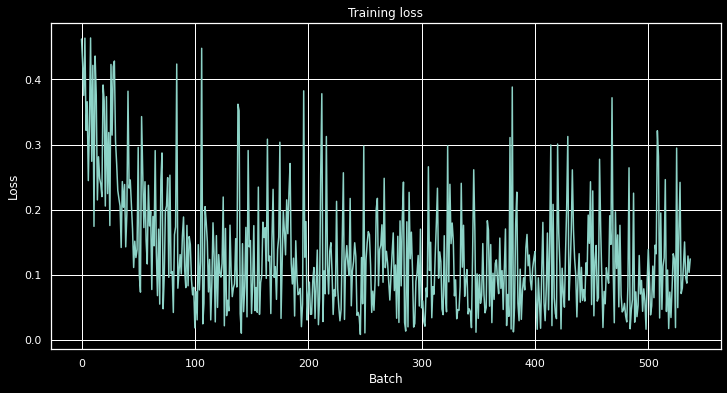

Loss на обучающей выборке: 0.13255
Процент правильных предсказаний на валидационной выборке: 95.92%


In [ ]:
# Будем сохранять loss во время обучения
# и рисовать график в режиме реального времени
train_loss_set = []
train_loss = 0


# Обучение
# Переводим модель в training mode
model.train()

for step, batch in enumerate(train_dataloader):
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    b_input_ids = torch. tensor(b_input_ids). to (torch. int64)
    # если не сделать .zero_grad(), градиенты будут накапливаться
    optimizer.zero_grad()
    
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

    train_loss_set.append(loss[0].item())  
    
    # Backward pass
    loss[0].backward()
    
    # Обновляем параметры и делаем шаг используя посчитанные градиенты
    optimizer.step()

    # Обновляем loss
    train_loss += loss[0].item()
    
    # Рисуем график
    clear_output(True)
    plt.plot(train_loss_set)
    plt.title("Training loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.show()
    
print("Loss на обучающей выборке: {0:.5f}".format(train_loss / len(train_dataloader)))

# Валидация
# Переводим модель в evaluation mode
model.eval()

valid_preds, valid_labels = [], []

for batch in validation_dataloader:   
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    b_input_ids = torch. tensor(b_input_ids). to (torch. int64)
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для валидационных данных.
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.array(label_ids)     
    valid_preds.extend(batch_preds)
    valid_labels.extend(batch_labels)

print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))

In [ ]:
print("f1_score: {0:.2f}%".format(
    f1_score(valid_labels, valid_preds)
))

f1_score: 0.78%


Делаем точно такую же предобработку для тестовых данных, как и в начале  делали для обучающих данных:

In [ ]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in test_sentences]
input_ids = [tokenizer.convert_tokens_to_ids(x[:MAX_LEN]) for x in tokenized_texts]

input_ids = pad_sequences(
    input_ids,
    maxlen=MAX_LEN,
    dtype="long",
    truncating="post",
    padding="post"
)

Создаем attention маски и приводим данные в необходимый формат:

In [ ]:
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(test_gt)

prediction_data = TensorDataset(
    prediction_inputs,
    prediction_masks,
    prediction_labels
)

prediction_dataloader = DataLoader(
    prediction_data, 
    sampler=SequentialSampler(prediction_data),
    batch_size=BATCH_SIZE
)

In [ ]:
model.eval()
test_preds, test_labels = [], []

for batch in prediction_dataloader:
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    b_input_ids = torch. tensor(b_input_ids). to (torch. int64)
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для тестовых данных.
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Сохраняем предсказанные классы и ground truth
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.array(label_ids)  
    test_preds.extend(batch_preds)
    test_labels.extend(batch_labels)   

In [ ]:
f1_score(test_labels, test_preds)

0.8301158301158301

## Выводы

В ходе выполнения проекта сделаны следующие этапы:


*   Загрузка данных и их предобработка
*   Моедлирование при помощи:

    *   TF-IDF и логистическая регрессия
    *   BERT

Модель BERT поеказала науилучший результат f1 = 0,83.